# **Study of energy dissipation for PTST ligament - PVW approach**

Study not included at Euro-C. The notebook can be reused for calibration

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from bmcs_matmod.ms1 import MS13DPVW
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [10]:
def get_total_work(m):
        
    total_work_microplane = np.zeros((len(m.hist.state_vars),4))
    total_work_macro = np.zeros((len(m.hist.state_vars),4))
    
    delta_eps_N_Emn = np.zeros((len(m.hist.state_vars),4,28))
    delta_eps_T_Emna = np.zeros((len(m.hist.state_vars),4,28,3))
    
    for i in range(1,len(m.hist.state_vars)):
        
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn =  m_inelastic._get_e_N_Emn(xmodel.map_U_to_field(m.hist.U_t[i]))
        delta_eps_N_Emn = m_inelastic._get_e_N_Emn(xmodel.map_U_to_field(m.hist.U_t[i])) - m_inelastic._get_e_N_Emn(xmodel.map_U_to_field(m.hist.U_t[i-1])) 
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn']])
        
        pos = eps_N_Emn - eps_N_p_Emn > 1e-15  # microplanes under tension
        pos2 = eps_N_Emn - eps_N_p_Emn < -1e-15
        tension = 1.0 * pos
        compression = 1.0 * pos2
        
        sigma_N = (1.0 - np.array([ m.hist.state_vars[i][0]['omega_N_Emn']]) ) * E_N * (eps_N_Emn - eps_N_p_Emn) * tension
        sigma_N = E_N * (eps_N_Emn - eps_N_p_Emn) * compression
        
        work_microplane = np.einsum('...n,...n->...n', sigma_N, delta_eps_N_Emn) 
        total_work_microplane[i] =  np.einsum('...n,...n->...', m_inelastic._MPW, work_microplane)
        
        sigma_Emab = xmodel.map_U_to_field(m.hist.F_t[i]/1000)
        delta_eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i]) - xmodel.map_U_to_field(m.hist.U_t[i-1])
        
        total_work_macro[i] = np.einsum('...ij,...ij->...', sigma_Emab, delta_eps_Emab) 
                                                 
                                                 
    return total_work_microplane, total_work_macro

In [3]:
# Reference parameters

CAxisymm = dict(
    E = 39226,
    nu = 0.18,
    Ad = 700.0,
    eps_0 = 0.00001,
    K_N = 100.,
    sigma_N_0 = 20.,
    gamma_N = 200.,
    sigma_T_0 = 0.5,
    K_T = 0.0,
    gamma_T = 500,
    S_T = 0.001,
    c_T = 6.,
    r_T = 4.,
    m_T = 0.0,
    p_T = 10.
)

## Unit element Axisymm - EEQ

In [14]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [15]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [16]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


## Monotonic - dc

In [18]:
m_list_monotnonic_EEQ = []
# CAxisymm['m_T'] = 0.15
# CAxisymm['p_T'] = 7
# m_inelastic = MS13D(**CAxisymm)
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([-15])

w_max = 0.1

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    slide = 0.05
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]
    

    
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5

    slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    
#     slide_upper[0].value *= 1.5
#     slide_upper[-1].value *= 0.5
    
    
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.02
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    s.run()
    # try:
    #     s.run()
    # except:
    #     # m_list_monotnonic.append(m)
    #     pass
    m_list_monotnonic_EEQ.append(m)

Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 700.0, 'eps_0': 1e-05, 'K_N': 100.0, 'sigma_N_0': 20.0, 'gamma_N': 200.0, 'sigma_T_0': 0.5, 'K_T': 0.0, 'gamma_T': 500, 'S_T': 0.001, 'c_T': 6.0, 'r_T': 4.0, 'm_T': 0.0, 'p_T': 10.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
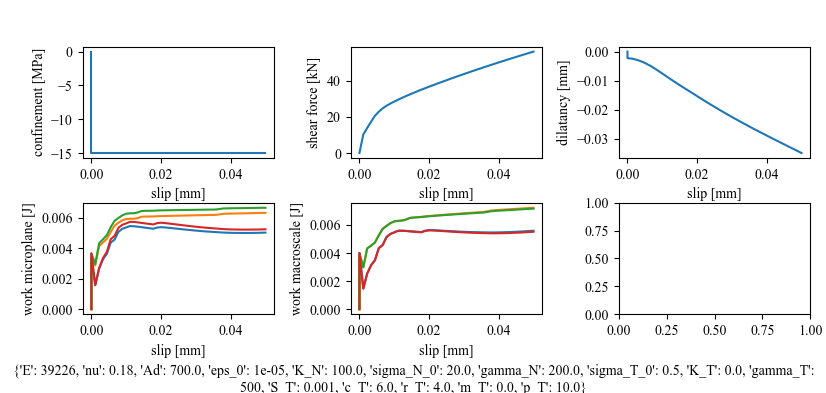

In [19]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))

for m,compression in zip(m_list_monotnonic_EEQ,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    total_work_microplane, total_work_macro = get_total_work(m)

    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    max_F.append(max(abs(F_slide)))
    
    ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]', fontsize=10)
    ax1.set_xlabel('slip [mm]', fontsize=10)
    
    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]', fontsize=10)
    ax2.set_xlabel('slip [mm]', fontsize=10)
    
    ax3.plot(U_slide, U_dilatancy, label=str(compression))
    ax3.set_ylabel('dilatancy [mm]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
    
    # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.plot(U_slide, total_work_microplane, label='radial damage'+str(compression))
    ax4.set_ylabel('work microplane [J]', fontsize=10)
    ax4.set_xlabel('slip [mm]', fontsize=10)
    
    ax5.plot(U_slide, total_work_macro, label='hoop damage'+str(compression))
    ax5.set_ylabel('work macroscale [J]', fontsize=10)
    ax5.set_xlabel('slip [mm]', fontsize=10)
    
    # # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
    # ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
    # ax6.set_ylabel('shear damage[-]', fontsize=10)
    # ax6.set_xlabel('slip [mm]', fontsize=10)
    # ax6.set_ylim(-0.05,1.05)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

## Unit element Axisymm - PVW

In [5]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13DPVW(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [6]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [7]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


## Monotonic - dc

In [8]:
m_list_monotnonic_PVW = []
# CAxisymm['m_T'] = 0.15
# CAxisymm['p_T'] = 7
# m_inelastic = MS13D(**CAxisymm)
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([-15])

w_max = 0.1

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    slide = 0.05
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]
    

    
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5

    slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    
#     slide_upper[0].value *= 1.5
#     slide_upper[-1].value *= 0.5
    
    
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.02
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    s.run()
    # try:
    #     s.run()
    # except:
    #     # m_list_monotnonic.append(m)
    #     pass
    m_list_monotnonic_PVW.append(m)

Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 700.0, 'eps_0': 1e-05, 'K_N': 100.0, 'sigma_N_0': 20.0, 'gamma_N': 200.0, 'sigma_T_0': 0.5, 'K_T': 0.0, 'gamma_T': 500, 'S_T': 0.001, 'c_T': 6.0, 'r_T': 4.0, 'm_T': 0.0, 'p_T': 10.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
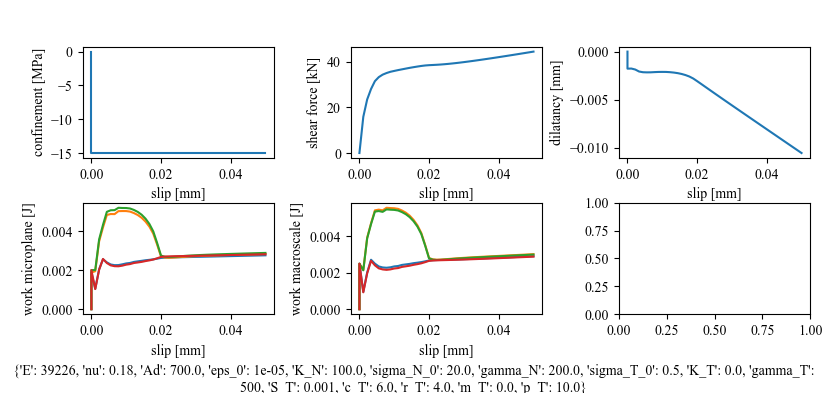

In [13]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))

for m,compression in zip(m_list_monotnonic_PVW,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    total_work_microplane, total_work_macro = get_total_work(m)

    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    max_F.append(max(abs(F_slide)))
    
    ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]', fontsize=10)
    ax1.set_xlabel('slip [mm]', fontsize=10)
    
    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]', fontsize=10)
    ax2.set_xlabel('slip [mm]', fontsize=10)
    
    ax3.plot(U_slide, U_dilatancy, label=str(compression))
    ax3.set_ylabel('dilatancy [mm]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
    
    # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.plot(U_slide, total_work_microplane, label='radial damage'+str(compression))
    ax4.set_ylabel('work microplane [J]', fontsize=10)
    ax4.set_xlabel('slip [mm]', fontsize=10)
    
    ax5.plot(U_slide, total_work_macro, label='hoop damage'+str(compression))
    ax5.set_ylabel('work macroscale [J]', fontsize=10)
    ax5.set_xlabel('slip [mm]', fontsize=10)
    
    # # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
    # ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
    # ax6.set_ylabel('shear damage[-]', fontsize=10)
    # ax6.set_xlabel('slip [mm]', fontsize=10)
    # ax6.set_ylim(-0.05,1.05)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()